# DM872 A Cutting Plane Approach for the Traveling Salesman Problem

Part of this script is taken from the very nice tutorial by Peter Norvig:
http://nbviewer.jupyter.org/url/norvig.com/ipython/TSP.ipynb

Consider the [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem):

> Given a set of cities and the distances between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?

## Representing an instance of the problem

The only thing that matters about cities is the distance between them. We will ignore the fully general TSP where distances can be defined in any arbitrary way and concentrate on an important special case, 
the *Euclidean TSP*, where the distance between any two cities is the Euclidean distance, the straight-line distance between points in a two-dimensional plane. 
So a city can be represented by a two-dimensional point: a pair of $x$ and $y$ coordinates in the Cartesian plane.
Python already has the two-dimensional point as a built-in numeric data type, 
but in a non-obvious way: as complex numbers, which inhabit the two-dimensional (real $\times$ imaginary) plane. We will use those but you will not have to care about this aspect as all functions to handle data are made available to you.

We will work with three predetermined, historical instances, `dantzig42.dat berlin52.dat bier127.dat`, and with randomly generated instances.
You can download the three instances from these links: [`dantzig42.dat`](http://imada.sdu.dk/~marco/DM559/Files/TSP/dantzig42.dat), 
[`berlin52.dat`](http://imada.sdu.dk/~marco/DM559/Files/TSP/berlin52.dat), 
[`bier127.dat`](http://imada.sdu.dk/~marco/DM559/Files/TSP/bier127.dat). 
In the file [tsputil.py](http://imada.sdu.dk/~marco/DM559/Files/TSP/tsputil.py) you will find the functions to read the instances from the files and to generate instances at random.  
The constructor function `City`, creates a city object, so that `City(300, 0)` creates a city with x-coordinate of `300` and y-coordinate of `0`. 
Then, `distance(A, B)` will be a function that uses the $x$ and $y$ coordinates to compute the distance between cities `A` and `B`.

Let's import the files:
```python
from tsputil import *
```

In [1]:
import pyomo.environ as po
from collections import OrderedDict

%run src/tsputil.py 
%matplotlib inline

We can then generate an instance of random points with the function `Cities(n,seed)`. The function returns a frozen set because these are the input data and cannot be modified. We plot the instance with `plot_situation`. When you generate an instance make sure that you use a seed number different from the one of other groups working at this project.

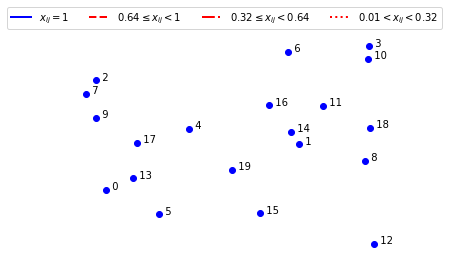

In [2]:
ran_points = list(Cities(n=20,seed=35))
plot_situation(ran_points)

Alternatively, we can read the `dantiz42.dat` instance which represents locations in USA.

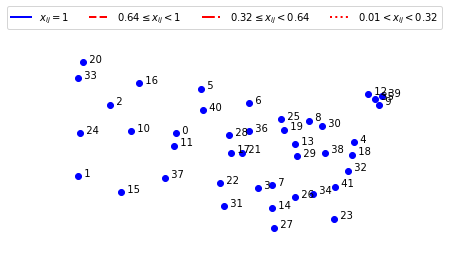

In [3]:
dantzig42 = read_instance("data/dantzig42.dat")
plot_situation(dantzig42)

## Dantzig, Fulkerson and Johnson (DFJ) Formulation

Consider the following formulation of the *symmetric traveling salesman
problem* due to Dantzig, Fulkerson and Johnson, 1954 (DFJ) that we have
been discussing during the course. Let $V=\{0..n-1\}$ be the set of nodes
and $E$ the set of edges. Let $E(S)$ be the set of edges induced by the
subset of vertices $S$ and $\delta(v)$ the set of edges in the cut
$(v,V\setminus\{v\})$. (We will assume that an edge between two nodes $i$ and $j$ is present in $E$ in the form $ij$ if $j>i$ and $ji$ if $ j < i $.) 
$$\begin{aligned}
\text{(TSPIP)}\quad \min\; & \sum c_{ij} x_{ij} \\
\text{s.t.}\;&\sum_{ij \in \delta(i)} x_{ij}+\sum_{ji \in \delta(i)}x_{ji}=2 \text{ for all } i \in V\\
\label{subtour}&\sum_{ij \in E(S)} x_{ij} \leq |S|-1 \text{ for all } \emptyset \subset S\subset V, 2 \leq |S| \leq n-1\\
&x_{ij} \in \{0,1\} \text{ for all } {ij} \in E\end{aligned}$$

We can generate all subsets of the set of 20 randomly generated cities as follows: 

In [4]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

subtours = list(powerset(range(len(ran_points))))
# The first element of the list is the empty set and the last element is the full set, hence we remove them.
subtours = subtours[1:(len(subtours)-1)]

print(len(subtours))
import sys
print(sys.getsizeof(subtours)/1024/1024," MB")

1048574
8.000045776367188  MB


### Task 1
Implement the DFJ formulation in the model below and solve your random instance:

In [42]:
def solve_tsp(points, subtours=[], vartype=po.Binary, solver="glpk", silent=True):
    points=list(points)
    V = list(range(len(points)))
    E = [(i,j) for i in V for j in V if i<j] # complete graph
    
    cost = {e: distance(points[e[0]],points[e[1]]) for e in E}
    
    m = po.ConcreteModel("TSP0")
     
    ######### BEGIN: Write here your model for Task 1
    m.x = po.Var(E, bounds=(0.0,1.0), within=vartype)
    
    ## Objective
    m.value = po.Objective(expr=sum(cost[e]*m.x[e] for e in E), sense=po.minimize)
    
    ## Constraints
    m.flow_balance=po.ConstraintList()
    for v in V:
        m.flow_balance.add(expr=sum(m.x[(v,i)] for i in V if (v,i) in E) + sum(m.x[(i,v)] for i in V if (i,v) in E) == 2)
    
    m.subtour_elimination=po.ConstraintList()
    for S in subtours:
        if len(S)>1:
            m.subtour_elimination.add(expr=sum(m.x[(i,j)] for i in S for j in S if i<j)<=len(S)-1)
                                  
    ######### END
    results = po.SolverFactory(solver).solve(m, tee=(not silent))

    m.write("tsplp.lp")
    
    if str(results.Solver.status) == 'ok':
        print('The optimal objective is %g' % m.value())
        return {e: po.value(m.x[e]) for e in E}
    else:
        print("Something wrong in solve_tsp")
        exit(0)

If we try to solve the small instance on 20 cities with this model, ie:
```python
solve_tsp(ran_points, [])
```
we get out of memory (you can be more lucky but if so try increasing your instance with a few more cities).

```python
solve_tsp(ran_points, subtours)
```

## A Cutting Plane Approach 

The number of subtour elimination constraints in the DFJ formulation can be huge ($2^n$) and even though we can
remove half of those due to symmetries, there are still exponentially
many. A way to deal with large families of constraints is to introduce
them only when needed. This idea is similar to the cutting plane
algorithm that we saw in the intro classes.
We start by solving the relaxed version of (TSPIP) obtained by removing
the integrality constraints and the exponentially many subtour
elimination constraints. We dub this relaxation TSPLP$_0$. Let $x^*$ be
the optimal solution of TSPLP$_0$.


### Task 2
Implement the new function `solve_tsp(points, subtours=[])` that solves the relaxed version TSPLP$_0$ and solve your random instance with 20 points. Inspect the plot of the solution obtained. 
```python
tsplp0 = solve_tsp(ran_points, subtours=[], vartype=po.NonNegativeReals)
plot_situation(ran_points, tsplp0)
```
Describe what you observe. Are all variables integer? Is the matrix TUM? Why? Is the solution a tour? Is the solution matching your expectations?

<span style="color:blue"> Relaxing only the subtour elimination constraints in `solve_tsp` we obtain: 

Using license file /Library/gurobi900/gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file /var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmpdqgl6hq3.pyomo.lp
Reading time = 0.02 seconds
x191: 21 rows, 191 columns, 381 nonzeros
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 21 rows, 191 columns and 381 nonzeros
Model fingerprint: 0xdc922c71
Variable types: 1 continuous, 190 integer (190 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 8528.3355431
Presolve removed 1 rows and 1 columns
Presolve time: 0.03s
Presolved: 20 rows, 190 columns, 380 nonzeros
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 2.853284e+03, 27 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

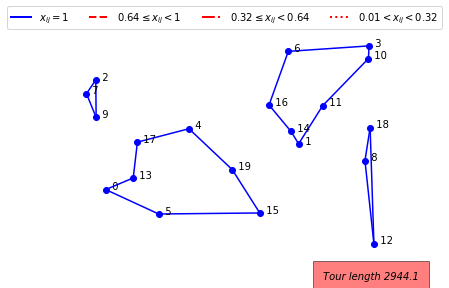

In [46]:
tsplp0 = solve_tsp(ran_points, subtours=[], solver="gurobi", vartype=po.Binary, silent=False)
plot_situation(ran_points, tsplp0)

The optimal objective is 3045.72


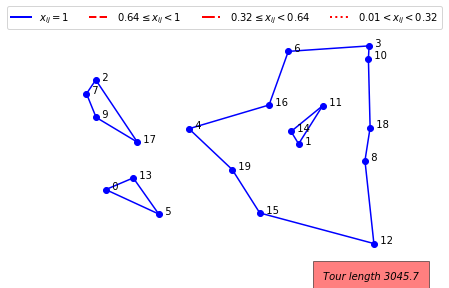

In [48]:
tsplp0 = solve_tsp(ran_points, [[2,7,9],[18,8,12]], po.Binary, solver="glpk", silent=True)
plot_situation(ran_points, tsplp0)

The optimal objective is 3165.93


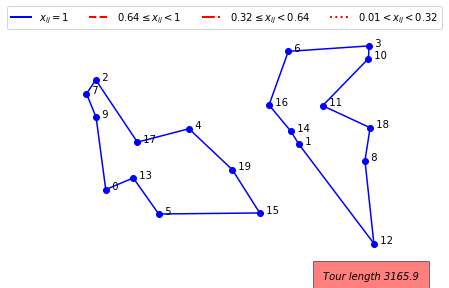

In [52]:
tsplp0 = solve_tsp(ran_points, [[2,7,9],[18,8,12],[2,7,9,17],[0,13,5],[1,14,11],[6,3,10],[2,7,9,17,13,5,0],[2,7,9,0,13,5,4,17]], po.Binary, solver="glpk", silent=True)
plot_situation(ran_points, tsplp0)

<span style="color:blue">Relaxing also the integrality constraints `vartype=po.NonNegativeReals` is more convenient since the solution will be faster:</span>

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmpawunl5fv.glpk.raw
 --wglp /var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmpg8ai8bnc.glpk.glp
 --cpxlp /var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmpj_728qez.pyomo.lp
Reading problem data from '/var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmpj_728qez.pyomo.lp'...
21 rows, 191 columns, 381 non-zeros
832 lines were read
Writing problem data to '/var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmpg8ai8bnc.glpk.glp'...
997 lines were written
GLPK Simplex Optimizer, v4.65
21 rows, 191 columns, 381 non-zeros
Preprocessing...
20 rows, 190 columns, 380 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 19
      0: obj =   9.320749676e+03 inf =   5.500e+01 (19)
     23: obj =   1.013873908e+04 inf =   0.000e+00 (0)
*

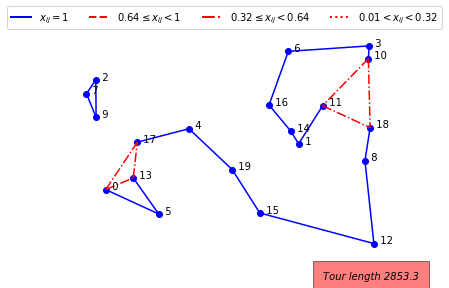

In [7]:
tsplp0 = solve_tsp(ran_points, [], vartype=po.NonNegativeReals, silent=False)
plot_situation(ran_points, tsplp0)

You should pay attention to the two different outputs of the solver. In particular, in the latter output with continuous variables you find the log of the iterations of the primal simplex, while in the output of the model with interger variables you find the log of the branch and bound process in which the 48 iterations of the LP relaxation at the root is summarized in one single row.
In the linear relaxation the variables are not all integer. The matrix is indeed not TUM because although we have only two terms different from zero in each column of the matrix, they are both positive and the graph is not bipartite, hence we are not able to separate the rows in the fashion described by the theorem on sufficient conditions for TUM. 
The solution is not a tour, since, as expected, there are subtours and fractional variables.

**An alternative directed graph formulation**.
Note that if we had used a directed representation of the problem, by introducing for each edge two oriented arcs then we would have had a TUM matrix, although the number of arcs would have been now double.
Let $A=\{ij\mid i\in V,j\in V,i\neq j\}$ and let $\delta^+(i)$ and $\delta^-(i)$ the set of arcs, respectively, outgoing and ingoing $i$:
$$\begin{aligned}
\text{(TSPIP)}\quad \min\; & \sum_{ij \in A} c_{ij} x_{ij} \\
\text{s.t.}\;&\sum_{ij \in \delta^+(i)} x_{ij}=1 \text{ for all } i \in V\\
&\sum_{ji \in \delta^-(i)} x_{ji}=1 \text{ for all } i \in V\\
&\sum_{ij \in A(S)} x_{ij} \leq |S|-1 \text{ for all } \emptyset \subset S\subset V, 2 \leq |S| \leq n-1\\
&x_{ij} \in \{0,1\} \text{ for all } {ij} \in E
\end{aligned}$$

In [8]:
def solve_tsp_directed(points, subtours=[], vartype=po.Binary, solver="glpk", silent=True):
    points=list(points)
    V = range(len(points))
    A = [(i,j) for i in V for j in V if i!=j] # complete graph
    cost = {a:distance(points[a[0]],points[a[1]]) for a in A}
    m = po.ConcreteModel("TSP0")
    
    ######### BEGIN: Write here your model for Task 1
    m.x=po.Var(A, bounds=(0.0, 1.0), within=vartype)

    m.value = po.Objective(expr=sum(cost[a]*m.x[a] for a in A), sense=po.minimize)
    ## Constraints
    m.mass_balance = po.ConstraintList()
    for v in V:
        m.mass_balance.add(sum(m.x[i,v] for i,j in A if j==v) == 1) # incoming_flow_balance
        m.mass_balance.add(sum(m.x[v,i] for j,i in A if j==v) == 1) # outgoing_flow_balance
    
    m.subtour_elimination = po.ConstraintList()
    for S in subtours:
        m.subtour_elimination.add(sum(m.x[(i,j)] for i in S for j in S if i!=j)<=len(S)-1)
    ######### END
    
    results = po.SolverFactory(solver).solve(m, tee=(not silent))

    if str(results.Solver.status) == 'ok':
        print('Solve TSP: the optimal objective value is %g' % po.value(m.value))   
        return {a : m.x[a]() for a in A}
    else:
        print("Something wrong in solve_tsplp")
        exit(0)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmp0q0pa373.glpk.raw
 --wglp /var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmp98m_u1pr.glpk.glp
 --cpxlp /var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmpv_njerw0.pyomo.lp
Reading problem data from '/var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmpv_njerw0.pyomo.lp'...
41 rows, 381 columns, 761 non-zeros
1652 lines were read
Writing problem data to '/var/folders/w9/sxcp2ljj4wq3fdhy78rf5djh0000gn/T/tmp98m_u1pr.glpk.glp'...
1987 lines were written
GLPK Simplex Optimizer, v4.65
41 rows, 381 columns, 761 non-zeros
Preprocessing...
40 rows, 380 columns, 760 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 39
      0: obj =   9.499897478e+03 inf =   1.800e+01 (3)
     41: obj =   8.670322722e+03 inf =   0.000e+00 (0)


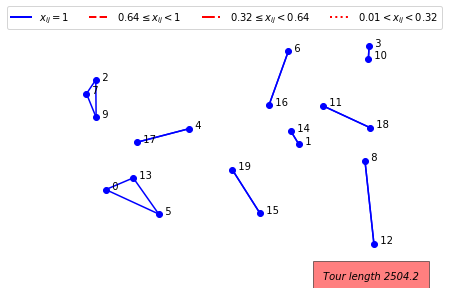

In [9]:
tsplp0 = solve_tsp_directed(ran_points, [], po.NonNegativeReals, "glpk", False)
plot_situation(ran_points, tsplp0)

<span style="color:blue">
As we see, an integer solution is found without need of a branch and bound (see the output of the solver). However, a side effect of considering a directed graph formulation is the fact that subtours of lenght 2 are not eliminated and we actually get 4 of them in the case above.
</span>

### Task 3 
Detect by visual inspection some subtour inequalities to add to TSPLP0. List those subtours in the subtour argument of the function `solve_tsp` and solve the new problem TSPLP$_1$=TSPLP$_0 \cup c$, where $c$ is the constraint added.
Report the visualization produced by `plot_situation` on the new solution. Is it a tour? If not iterate this procedure until you cannot find anymore subtours. Show your last solution and comment on it. 

<span style="color:blue">
#### Solution 
</span>

The optimal objective is 2944.06


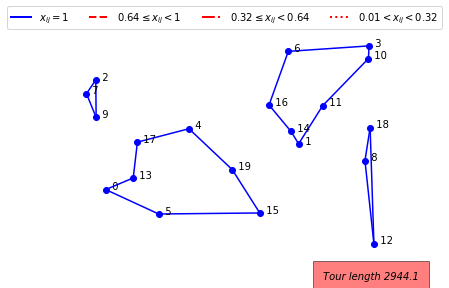

In [10]:
tsplp0 = solve_tsp(ran_points, [], po.Binary)
plot_situation(ran_points, tsplp0)

The optimal objective is 3045.72


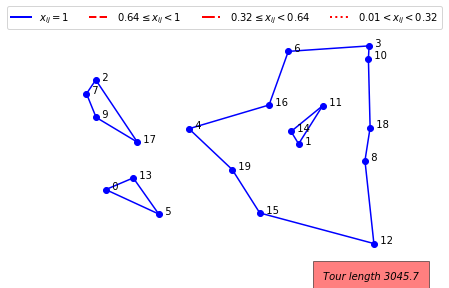

In [11]:
tsplp1 = solve_tsp(ran_points, [[2,7,9], [0,13,17,4,19,15,5], [12,8,18], [3,6,16,14,1,11,10]], po.Binary)
plot_situation(ran_points, tsplp1)

The optimal objective is 3136.08


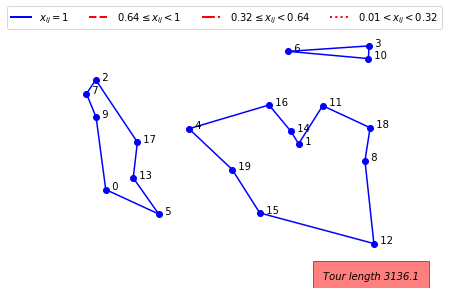

In [12]:
tsplp1 = solve_tsp(ran_points, [[2,7,9], [0,13,17,4,19,15,5], [12,8,18], [3,6,16,14,1,11,10], 
                                [3,6,16,4,19,15,12,8,18,10],[2,7,9,17],[0,13,5],[11,1,14]], po.Binary)
plot_situation(ran_points, tsplp1)

The optimal objective is 3149.14


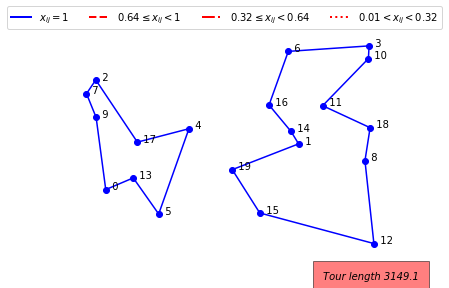

In [14]:
tsplp1 = solve_tsp(ran_points, [[2,7,9], [0,13,5], [3,6,16,14,1,11,10], 
                                [3,6,16,14,1,11,18,10],[2,7,9,17],
                                [6,16,14,1,12,8,18,11,10,3],[2,7,9,0,13,17],
                               [2,7,9,0,5,13,17],[11,14,1],[4,19,15,12,8,18,10,3,6,16]], po.Binary)
plot_situation(ran_points, tsplp1)

The optimal objective is 3180.29


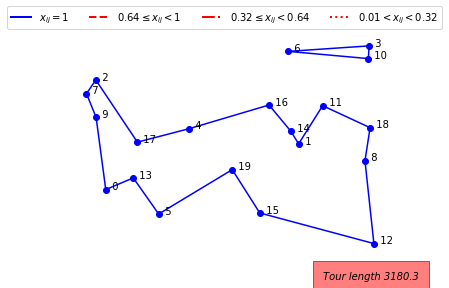

In [15]:
tsplp1 = solve_tsp(ran_points, [[2,7,9], [0,13,5], [3,6,16,14,1,11,10], 
                                [3,6,16,14,1,11,18,10],[2,7,9,17],
                                [6,16,14,1,12,8,18,11,10,3],[2,7,9,0,13,17],
                               [2,7,9,0,5,13,17],[11,14,1],[4,19,15,12,8,18,10,3,6,16],
                               [2,7,9,0,13,5,4,17],[19,15,12,8,18,11,10,3,6,16,14,1]], po.Binary)
plot_situation(ran_points, tsplp1)

The optimal objective is 3182.28


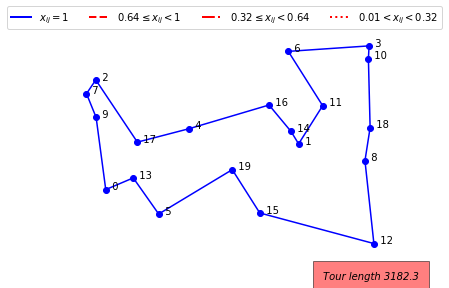

In [16]:
tsplp1 = solve_tsp(ran_points, [[2,7,9], [0,13,5], [3,6,16,14,1,11,10], 
                                [3,6,16,14,1,11,18,10],[2,7,9,17],
                                [6,16,14,1,12,8,18,11,10,3],[2,7,9,0,13,17],
                               [2,7,9,0,5,13,17],[11,14,1],[4,19,15,12,8,18,10,3,6,16],
                               [2,7,9,0,13,5,4,17],[19,15,12,8,18,11,10,3,6,16,14,1],
                               [6,3,10]], po.Binary)
plot_situation(ran_points, tsplp1)

<span style="color:blue"> We might finally find a tour continuing in this way and that would be an optimal solution since it would satisfy all DFJ constraints. However, in the general case we could have no subtour constraints unsatisfied but a solution not yet integer. This is for example the case for the instance `dantzig42` as we will see below.</span>

### Task 4
We can automatize the manual process described above. 
Let $V'=V\setminus\{0\}$ and $E'=E\setminus\{\delta(0)\}$. A set
$S\subseteq V'$ that contains a vertex $k$ forms a subtour in $x^*$ if
$$\sum_{e=ij \in E'(S)} x_e^* > |S \setminus \{k\} |=|S|-1.$$ 

We can find the subtour elimination constraint that is most violated by $x^*$ by solving
the following *separation problem* for $k=\{1..n-1\}$. Let’s represent the
unknown set $S \subseteq V'$ by binary variables $z$ with $z_i=1$ if
$i \in S$ then the separation problem for $k=\{1..n-1\}$ is

$$ (SEP) \quad \xi_k=\max \left\{ \sum_{e=ij\in E':i < j} x^*_e z_i z_j - \sum_{i
  \in V' \setminus \{k\}} z_i : z \in \mathbb{B}^n, z_k=1\right\} $$ 

If $ \xi_k > 0 $ for some $k$ then the solution $z^*$ of SEP gives a subtour
$S$, containing $k$, whose corresponding subtour elimination constraint
in TSPIP is violated by $x^*$. We insert this constraint in TSPLP$_0$
and solve the new problem TSPLP$_1$.

Rewrite the (SEP) problem for some $k$ as an integer linear program and report the mathematical model in your answers.

<span style="color:blue">
**Solution**


We introduce the variables $y_{e}$ with $y_{e}=1$ if $z_i=z_j=1$ for $e=ij \in E'$ with $i<j$, and we obtain the integer program

$$\begin{aligned}
\text{(SEPILP)}\quad \xi_k=\max\; & \sum_{e \in E'} x_e^* y_e-\sum_{i \in V'\setminus\{k\}} z_i \\
\label{sep1}\text{s.t.}\;&y_e \leq z_i \text{ for } e=ij \in E'\\
\label{sep2}&y_e \leq z_j \text{ for } e=ij \in E'\\
\label{sep3}&y_e \geq z_i+z_j-1 \text{ for } e=ij \in E'\\
&z_k=1\\
&y \in \{0,1\}^{|E'|}, z\in \{0,1\}^{|V'|}\end{aligned}$$
**End Solution**
</span>

### Task 5
Implement your model in the function `solve_separation(points, x_star, k)` below and solve the **LP relaxation of the (SEP) problem** to separate the optimal solution $x^*$ of TSPLP$_0$.

In [32]:
def solve_separation(points, x_star, k, vartype=po.Reals, solver="glpk", silent=True):
    points = list(points)
    V = list(range(len(points)))
    Vprime = list(range(1, len(points)))
    E = [(i, j) for i in V for j in V if i < j]
    Eprime = [(i, j) for i in Vprime for j in Vprime if i < j]

    m = po.ConcreteModel("SEP")
    #m.setParam("limits/memory", 32000)
    #m.setParam("limits/time", 10)  # maximal time in seconds to run

    # BEGIN: Write here your model for Task 5
    m.y = po.Var(Eprime, bounds=(0.0, 1.0), within=vartype)
    m.z = po.Var(Vprime, bounds=(0.0,1.0), within=vartype)

    m.value = po.Objective(expr=sum(x_star[e]*m.y[e] for e in Eprime)-sum(m.z[v] for v in Vprime if v!=k), sense=po.maximize)

    m.k = po.Constraint(expr=m.z[k]==1)

    m.y_constraints = po.ConstraintList()
    for i, j in Eprime:
        m.y_constraints.add(m.y[i, j] <= m.z[i])
        m.y_constraints.add(m.y[i, j] <= m.z[j])
        m.y_constraints.add(m.y[i, j] >= m.z[i]+m.z[j]-1)

    # END
    results = po.SolverFactory(solver).solve(m, tee=(not silent))
    
    if str(results.Solver.status) == 'ok':
        print(('Separation problem solved for k=%d, solution value %g' % (k, m.value())))
        # BEGIN: Write here the subtour found from the solution of the model
        # it must be a list of points
        subtour = []
        subtour = list(filter(lambda i: m.z[i]() >= 0.99, Vprime))
        # END
        return m.value(), subtour
    else:
        print("Something wrong in solve_separation")
        exit(0)

Try your implementation of `solve_separation` on your previous TSPLP$_0$ solution. Do you get the expected answer?

**Solution**

The optimal objective is 2853.28


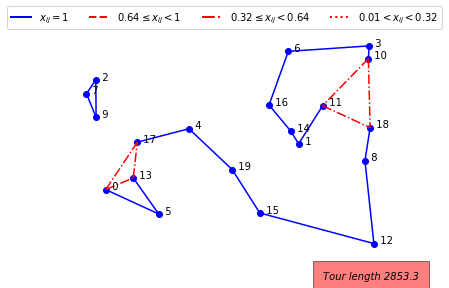

Separation problem solved for k=12, solution value 0.5
(0.5, [1, 3, 6, 8, 10, 11, 12, 14, 16, 18])


In [33]:
tsplp0 = solve_tsp(ran_points, [], po.Reals)
plot_situation(ran_points, tsplp0)
S_star = solve_separation(ran_points, tsplp0, 12, vartype=po.Reals)
print(S_star)

<span style="color:blue">
This means that by solving for the vertex k=12 we find the set S that contains 12 and violates the most the subtour elimination constraint.
We could now solve for all other k's or already insert the elimination constraint for the found subtour.
</span>

### Task 6
The following procedure `cutting_plane_alg` implements the cutting plane algorithm that uses your implementation of `solve_tsp` and `solve_separation`.
Finish the implementation of the function. That is: add the condition for the
    presence of violated inequalities. 

**Solution**

In [39]:
def cutting_plane_alg(points):
    Vprime = list(range(1, len(points)))
    subtours = []
    lpsol = []
    found = True
    while found:
        lpsol = solve_tsp(points, subtours, vartype=po.Reals)
        plot_situation(points, lpsol)
        found = False
        tmp_subtours = []
        best_val = float('-inf')
        for k in Vprime:
            value, subtour = solve_separation(points, lpsol, k, vartype=po.Reals, silent=True)
            best_val = value if value > best_val else best_val
            # BEGIN: write here the condition. Include a tollerance
            if value > 0.0001:
                # END
                found = True
                tmp_subtours += [subtour]
                subtours += tmp_subtours
        print('*'*60)
        print("********** Subtours found: ", tmp_subtours, " with best value : ", best_val)
        print('*'*60)
    plot_situation(points, lpsol)
    return lpsol

<span style="color:blue">
We added the condition `value>0`.
</span>

Run the cutting plane algorithm
    thus implemented until termination. Report the plot of the last
    solution found by solving the TSPLP$_n$ problem, where $n$ is the
    number of iterations in which violated inequalities were found. Is
    the solution optimal?

**Solution**

The optimal objective is 2853.28


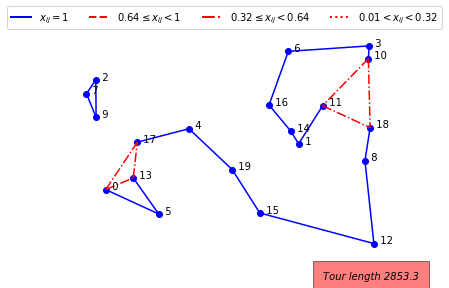

Separation problem solved for k=1, solution value 0.5
Separation problem solved for k=2, solution value 1
Separation problem solved for k=3, solution value 0.5
Separation problem solved for k=4, solution value 0.5
Separation problem solved for k=5, solution value 0
Separation problem solved for k=6, solution value 0.5
Separation problem solved for k=7, solution value 1
Separation problem solved for k=8, solution value 0.5
Separation problem solved for k=9, solution value 1
Separation problem solved for k=10, solution value 0.5
Separation problem solved for k=11, solution value 0.5
Separation problem solved for k=12, solution value 0.5
Separation problem solved for k=13, solution value 0
Separation problem solved for k=14, solution value 0.5
Separation problem solved for k=15, solution value 0.5
Separation problem solved for k=16, solution value 0.5
Separation problem solved for k=17, solution value 0.5
Separation problem solved for k=18, solution value 0.5
Separation problem solved for

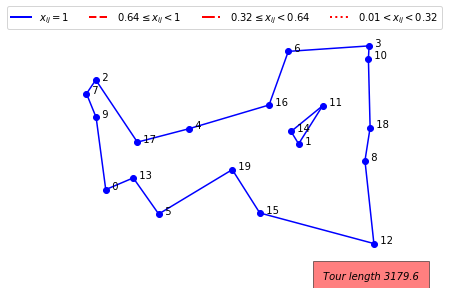

Separation problem solved for k=1, solution value 1
Separation problem solved for k=2, solution value 0
Separation problem solved for k=3, solution value 0
Separation problem solved for k=4, solution value 0
Separation problem solved for k=5, solution value 0
Separation problem solved for k=6, solution value 0
Separation problem solved for k=7, solution value 0
Separation problem solved for k=8, solution value 0
Separation problem solved for k=9, solution value 0
Separation problem solved for k=10, solution value 0
Separation problem solved for k=11, solution value 1
Separation problem solved for k=12, solution value 0
Separation problem solved for k=13, solution value 0
Separation problem solved for k=14, solution value 1
Separation problem solved for k=15, solution value 0
Separation problem solved for k=16, solution value 0
Separation problem solved for k=17, solution value 0
Separation problem solved for k=18, solution value 0
Separation problem solved for k=19, solution value 0
**

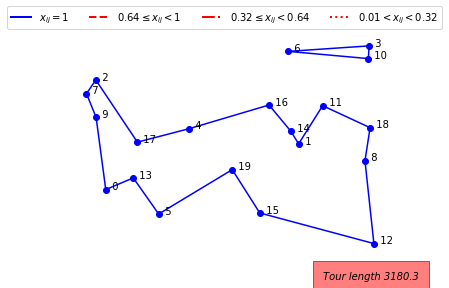

Separation problem solved for k=1, solution value 0
Separation problem solved for k=2, solution value 0
Separation problem solved for k=3, solution value 1
Separation problem solved for k=4, solution value 0
Separation problem solved for k=5, solution value 0
Separation problem solved for k=6, solution value 1
Separation problem solved for k=7, solution value 0
Separation problem solved for k=8, solution value 0
Separation problem solved for k=9, solution value 0
Separation problem solved for k=10, solution value 1
Separation problem solved for k=11, solution value 0
Separation problem solved for k=12, solution value 0
Separation problem solved for k=13, solution value 0
Separation problem solved for k=14, solution value 0
Separation problem solved for k=15, solution value 0
Separation problem solved for k=16, solution value 0
Separation problem solved for k=17, solution value 0
Separation problem solved for k=18, solution value 0
Separation problem solved for k=19, solution value 0
**

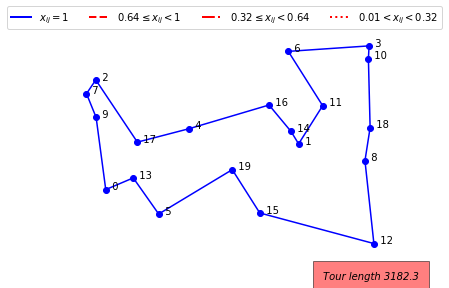

Separation problem solved for k=1, solution value 0
Separation problem solved for k=2, solution value 0
Separation problem solved for k=3, solution value 0
Separation problem solved for k=4, solution value 0
Separation problem solved for k=5, solution value 0
Separation problem solved for k=6, solution value 0
Separation problem solved for k=7, solution value 0
Separation problem solved for k=8, solution value 0
Separation problem solved for k=9, solution value 0
Separation problem solved for k=10, solution value 0
Separation problem solved for k=11, solution value 0
Separation problem solved for k=12, solution value 0
Separation problem solved for k=13, solution value 0
Separation problem solved for k=14, solution value 0
Separation problem solved for k=15, solution value 0
Separation problem solved for k=16, solution value 0
Separation problem solved for k=17, solution value 0
Separation problem solved for k=18, solution value 0
Separation problem solved for k=19, solution value 0
**

In [41]:
sol = cutting_plane_alg(ran_points)

<span style="color:blue">
We find the same optimal solution as eariler.
In the `cutting_plane` function above we are reconstructing the model from scrtach everytime. This can be improved by working incrementally and letting the solver restart from the previously solution found. In the next task, you will find a link to a more efficient implementation.
</span>

**End Solution**

### Task 7 (Optional)
Reflecting upon the process implemented you may wonder whether we
    are gaining anything in efficiency. After all we circumvented having
    to solve the original integer programming formulation of the TSP by
    having to solve many separation problems, which are in principle all
    integer programming problems and hence possibly hard to solve. It
    turns out that the SEP problems are actually solvable efficiently.
    In task 5, you were given the tip to implement the LP relaxation of
    the SEP problem. Why are the solutions to SEP always integer? It
    turns out that the SEP corresponds to one problem treated during
    the course. Which one? In efficient implementations the SEP problem
    is solved by specialized algorithms for this problem. \[Hint: It may
    help to consider the other way to formulate subtour elimination
    constraints, that is, cut-set constraints.\]

**Solution**


Solutions to the LP relaxation of (SEP) are always integer because
the matrix is TUM. (Since $x^*\geq 0$ then we wish $y_e$ as large
as possible. Thus by: $y_e=\min(z_i,z_j)$ and
$\min(z_i,z_j)\geq z_i+z_j-1$ is always satisfied and can
be dropped. We are left with a matrix with a block that contains
only two consecutive ones on each column (for the variables $y$)
concatenated with two identity matrices (for the variables $z$).
Such a matrix can be shown to be TUM (consecutive ones can be
rearranged and a partition satisfying the sufficiency conditions
found + concatation with identity matrices preserve TUM properties).

The separation problem can be solved by running a max flow algorithm
from any vertex $k$ as source to any other vertex as target and
$x^*$ as capacity on the arcs oriented from source to tank. This can
be better seen from the dual of the (SEP) problem that gives an
arc-incidence matrix. Another way to see this is the following.
Consider the alternative cut set constraints in place of the subtour
elimination constraints :
$$\sum_{e\in \delta(S)} x_e\geq 2, \forall \emptyset \subset S \subset V$$
which imposes that every solution must cross every demarcation line
separating the set of cities into two nonempty parts at least twice.
Let $N_{kt}(x)$ be the network with arcs obtained from $E$ oriented
from a source vertex $k\in V$ to an arbitrary fixed tank vertex
$t\in V$ and capacity $x^*$ on these arcs. Any nonempty proper
subset $S$ of $V$ that generates a cut $N_{kt}(x)$ with $k$ in $S$
and $t$ in $V\setminus S$ with capacity less than 2 corresponds to a
set $S$ violating the cut separation constraint. One such set, if it
exists, can be found by solving a *global minimum cut problem* in
$N_{kt}(x)$ from any vertex $k$ to an arbitrary fixed vertex $t$
(the choice does not matter). If we use the push-relabel algorithm
the complexity of each single max flow-min cut problem is $O(n^2m)$
and since we need to solve it $n-1$ times for all $k$ the total
complexity of the separation problem becomes $O(n^4m)$. The
procedure is implemented in Concorde in a very efficient
way @AppBixChvCoo06 [page 170]. 


The problem to solve is the *global min cut problem*, which can be
solved solving $n-1$ min cut problems. The MIP formulation of the
min cut problem is the dual the maximum flow problem.
Hence for $k=\{2..n\}$ and an arbitrarily chosen $t$:
$$\begin{aligned}
\min\;& \alpha_{ij}x^*_{ij}\\
&u_i-u_j+\alpha_{ij}\geq 0 \quad  \forall ij \in E'\\
&u_k-u_t\geq 1\\
&u_k=1\\
&u_i\in \{0,1\}\quad \forall i \in V'\\
&\alpha_{ij}\geq 0 \quad \forall ij \in E'\\\end{aligned}$$ 



**End Solution**

### Task 8 (Optional)
In task 6, you run the cutting plane algorithm until no cutting
    plane can be found anymore. Is this cutting plane algorithm enough
    to solve your instance to optimality? What about the general case on
    any arbitrary instance? Write your considerations and conclusions.
    \[Hint: try the whole procedure on the instances `dantzig42.dat` and `berlin52.dat` to see what happens in the general case. Report the
    final plots on these instance.\]

**Solution**


As argued before, the solution found to the random instance
is optimal.


For the instance with 20 vertices it would have been possible to
generate all cuts at the beginning and solve the IP once. For the
instance `berlin52.dat`, the number of constraints would be simply
too large to enumerate. We need therefore to use the dynamic
procedure illustrated in this assignment. If we apply the procedure to
the `berlin52.dat` example we finish again with an integer solution
that is a tour and hence it is optimal. For the instance `dantzig42`
however the last solution, TSPLP$_5$ has no subtour elimination
constraint to add, that is $\xi\leq 0$ for all $k$. Nevertheless
the solution is not integer. See Figure. This is
due to the fact that the formulation of the TSP given at the
beginning of Task 2 is not tight, that is, it is not the description
of the convex hull. We do not know the formulation of the convex
hull for the TSP problem. What one could do is to proceed by
applying further tighter constraints such as the comb constraints.
Alternatively one could reinsert the integrality constraints in the
problem TSP$_5$ and continue the cutting plane procedure with branch and bound from there.

In [ ]:
cutting_plane_alg(dantzig42,True)

### Task 9
Provide the length of the optimal tour of your problem on 20 nodes.

See above.

### Task 10

Already an instance on 127 vertices is challenging for
    our implementation. Try your cutting plane procedure on the instance
    `bier127.dat`, which asks to find the shortest tour among the 127
    biergardens in Augsburg, Bavaria. You will have to comment the line
    for plotting at each iteration, since it is inefficient. Moreover it
    might be convenient not to wait for all $k$s to be evaluated but to
    insert a cut as soon as one is found.

### Task 11

Experiment ideas: 
- combine the DFJ cutting plane procedure with integrality constraints 
- solve the separation problems in a more efficient way, for example, with network flow algorithms 

Keeping the integrality constraints in the DFJ formulation but relaxaing the subtour elimination conditions we can solve the separation problem with an algorithm that determines the connected components of a graph, if we have more than one connected component, each connected components is a subtour to eliminate. Connected components can be found by breath first.

An implementation of this procedure using the module `networkx` can be found in the repository: [tsp_cc.py](https://github.com/DM872/Material/blob/master/TSP/src/tsp_cc.py)

Relaxing the integrality constraints in the DFJ formulation we can solve the separation problem with a max flow - min cut algorithm, as explained above. An implementation using `networkx` is available in the repository: [tsp_maxflow.py](https://github.com/DM872/Material/tree/master/TSP/src/tsp_maxflow.py).

**To Do: time comparison**